Project: Cisco Data Centre Analytics
**bold text**


In [2]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

Mounted at /content/drive


Create a Spark Session & Load Data
Do not change this. Standard initialization for the Spark session within colab.

In [3]:
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark

findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [4]:
# import pacakges required
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import sum,avg,max,count,format_number
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD,Adam, RMSprop
from keras.utils import plot_model


from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing
df = pd.read_csv('/content/drive/My Drive/lstm_dataset.csv', sep=',', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.shape

(4880, 8)

In [13]:
df = df[['Power Consumption','CPU Usage', 'Fan1 Speed', 'Fan2 Speed',
       'Fan3 Speed', 'CPU Sensor1 Temp', 'CPU Sensor2 Temp']]

def toSupervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [14]:

df_resample = df.resample('h').mean()
df_resample.shape

df_resample.isnull().sum()
df_resample = df_resample.fillna(df.mean())


In [15]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
reframed = toSupervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
# r = list(range(df.shape[1]+1, 2*df.shape[1]))4
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/50
58/58 - 3s - loss: 0.0425 - val_loss: 0.0030 - 3s/epoch - 46ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0012 - val_loss: 0.0030 - 331ms/epoch - 6ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0012 - val_loss: 0.0029 - 355ms/epoch - 6ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0012 - val_loss: 0.0029 - 370ms/epoch - 6ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 343ms/epoch - 6ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0012 - val_loss: 0.0029 - 357ms/epoch - 6ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 324ms/epoch - 6ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 361ms/epoch - 6ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 313ms/epoch - 5ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 374ms/epoch - 6ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 350ms/epoch - 6ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0011 - val_loss: 0.0029 - 345ms/epoch - 6ms/step
Epoch 13/50
58/58 - 0s - lo

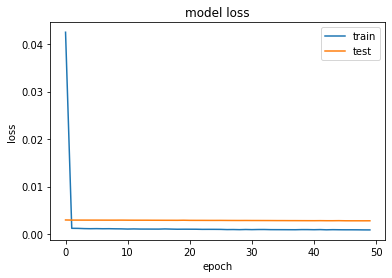

127/127 [==============================] - 1s 1ms/step


Test RMSE: 0.858


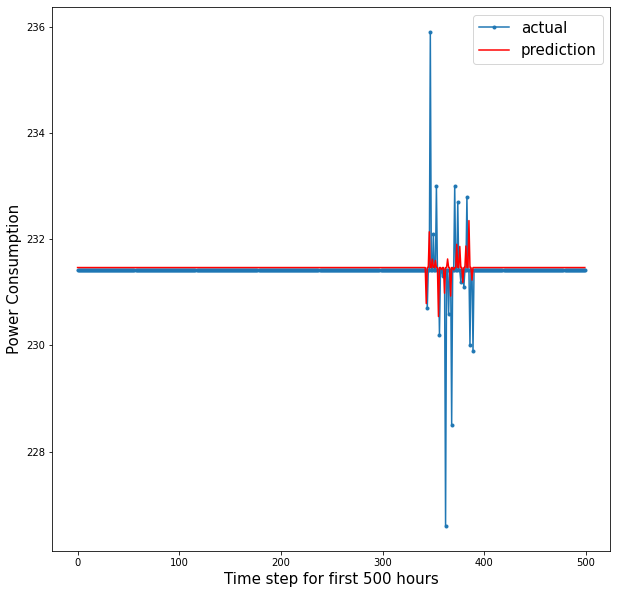

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np


values = df_resample.values
# values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = toSupervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
# r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()


# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print("\n")
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(10,10)) 
plt.plot(aa, inv_y[0:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()